In [1]:
%matplotlib inline

In [2]:
import os.path
import pylab as pl
import numpy as np
import pwkit.environments.casa.tasks as tasks
import pwkit.environments.casa.util as util
from astropy import coordinates, units
qa = util.tools.quanta()
me = util.tools.measures()

In [3]:
# define functions

def convertms(sdmfile, msfile, scan):
    %sx asdm2MS $sdmfile $msfile -s $scan
    
def applycal(msfile, gaintables, gainfield=None, targetfield=None, interp=None):
    if not gainfield:
        gainfield = ['' for _ in range(len(gaintables))]

    if not interp:
        interp = ['' for _ in range(len(gaintables))]

    if not targetfield:
        targetfield = '1'
        
    cfg = tasks.ApplycalConfig()
    cfg.vis = msfile
    cfg.gaintable = gaintables
    cfg.gainfield = gainfield
    cfg.field = targetfield
    cfg.interp = interp
    cfg.calwt = [False]
    tasks.applycal(cfg)

def makeimage(msfile, field='1', niter=50, cell=0.25, npix=4096, spw=''):
    %sx rm -rf $msfile?*
    cfg = tasks.MfscleanConfig()
    cfg.vis = msfile
    cfg.imbase = msfile
    cfg.field = field
    cfg.niter = niter
    cfg.stokes = 'I'
    cfg.cell = cell
    cfg.imsize = [npix, npix]
    cfg.spw = spw
    tasks.mfsclean(cfg)
    
def fitimage(image, displaywindow=100, fitwindow=100, returnimfit=False):
    # load image
    ia = util.tools.image()
    ia.open(image)

    # summarize image
    dd = ia.summary()
    npixx,npixy,nch,npol = dd['shape']
    print('Image shape: {0}'.format(dd['shape']))
    imvals = ia.getchunk(0, int(npixx))[:,:,0,0]
    peakx, peaky = np.where(imvals.max() == imvals)
    print('Peak SNR at ({0},{1}) = {2}'.format(peakx[0], peaky[0], imvals.max()/imvals.std()))
    print('Beam shape: {0}'.format(ia.history()[1].split('\n')[10].split(':')[5]))
    
    # fit component and write residual image
    box = '{0},{1},{2},{3}'.format(peakx[0]-fitwindow/2, peaky[0]-fitwindow/2, 
                                   peakx[0]+fitwindow/2, peaky[0]+fitwindow/2)
    imfit = ia.fitcomponents(box=box, residual=msfile + 'fitresid')

    # report on fit
    if imfit['converged']:
        print('{0} element(s) fit'.format(imfit['results']['nelements']))
        direction = imfit['results']['component0']['shape']['direction']

        az = direction['m0']['value']
        el = direction['m1']['value']
        az_err = direction['error']['latitude']['value']
        el_err = direction['error']['longitude']['value']
        peak_ra = qa.formxxx(qa.angle(qa.quantity(az, unitname='rad'), prec=9)[0], format='hms')
        peak_dec = qa.formxxx(qa.angle(qa.quantity(el, unitname='rad'), prec=9)[0], format='dms')
        print('{0} +- {1}"'.format(peak_ra, az_err))
        print('{0} +- {1}"'.format(peak_dec, el_err))
        print('Fiteak flux: {0} Jy'.format(imfit['results']['component0']['peak']['value']))
    else:
        print('fitcomponents did not converge')
    
    # load residuals
    ia = util.tools.image()
    ia.open(msfile + 'fitresid')
    dd = ia.summary()
    npixx,npixy,nch,npol = dd['shape']
    residvals = ia.getchunk(0, int(npixx))[:,:,0,0]
    peakx_resid, peaky_resid = np.where(residvals.max() == residvals)
    print('Residual SNR at ({0},{1}) = {2}'.format(peakx_resid[0], peaky_resid[0], residvals.max()/residvals.std()))

    # show results
    pl.figure(figsize=(15,8))
    pl.subplot(131)
    pl.imshow(np.log(imvals.transpose() - imvals.min()), interpolation='nearest', origin='bottom')
    pl.colorbar()
    pl.subplot(132)
    pl.imshow(imvals[peakx[0]-displaywindow/2:peakx[0]+displaywindow/2, 
                     peaky[0]-displaywindow/2:peaky[0]+displaywindow/2],
              interpolation='nearest', origin='bottom')
    pl.colorbar()
    pl.subplot(133)
    pl.imshow(residvals[peakx[0]-displaywindow/2:peakx[0]+displaywindow/2, 
                        peaky[0]-displaywindow/2:peaky[0]+displaywindow/2],
              interpolation='nearest', origin='bottom')
    pl.colorbar()
    
    if returnimfit:
        return imfit
    else:
        return az, el, az_err, el_err
    
    
def getimage(image):
    # load image
    ia = util.tools.image()
    ia.open(image)

    # summarize image
    dd = ia.summary()
    npixx,npixy,nch,npol = dd['shape']
    print('Image shape: {0}'.format(dd['shape']))
    imvals = ia.getchunk(0, int(npixx))[:,:,0,0]
    peakx, peaky = np.where(imvals.max() == imvals)
    print('Peak SNR at ({0},{1}) = {2}'.format(peakx[0], peaky[0], imvals.max()/imvals.std()))
    print('Beam shape: {0}'.format(ia.history()[1].split('\n')[10].split(':')[5]))
    
    return imvals

In [4]:
fits = {}

## 57623

In [5]:
#bdf_dedisperse_cut.py -i 6:36024:1 -d 565.0 16A-459_TEST_1hr.57623.72670021991
sdmfile = '16A-459_TEST_1hr.57623.72670021991.ddcut'
msfile = sdmfile + 'ms'
scan = 6
caltables = ['../pipeline/57623/caltables/cal_57623_3s.G4', '../pipeline/57623/caltables/cal_57623_3s.K4',
             '../pipeline/57623/caltables/cal_57623_3s.B4', '../pipeline/57623/caltables/selfcal.g0']

In [6]:
convertms(sdmfile, msfile, scan)

msm = util.tools.msmetadata()
msm.open(msfile)
fieldnames = msm.fieldnames()
print(fieldnames)
targetfield = str(fieldnames.index('FRB121102-off'))

applycal(msfile, caltables, targetfield=targetfield, gainfield=['0','','', ''], interp=['linear','','', ''])
makeimage(msfile, field=targetfield, niter=30)

['J0555+3948', 'FRB121102-off']


Image shape: [4096 4096    1    1]
Peak SNR at (2365,2495) = 27.3667139737
Beam shape:  2.8491 by 2.33929 (arcsec) at pa 70.4117 (deg) 
1 element(s) fit
05:31:58.68 +- 0.0472464756635"
+033.08.52.651 +- 0.0692105710322"
Fiteak flux: 0.0375646411808 Jy
Residual SNR at (2508,2414) = 6.09966419342


/users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:86: RuntimeWarning: divide by zero encountered in log


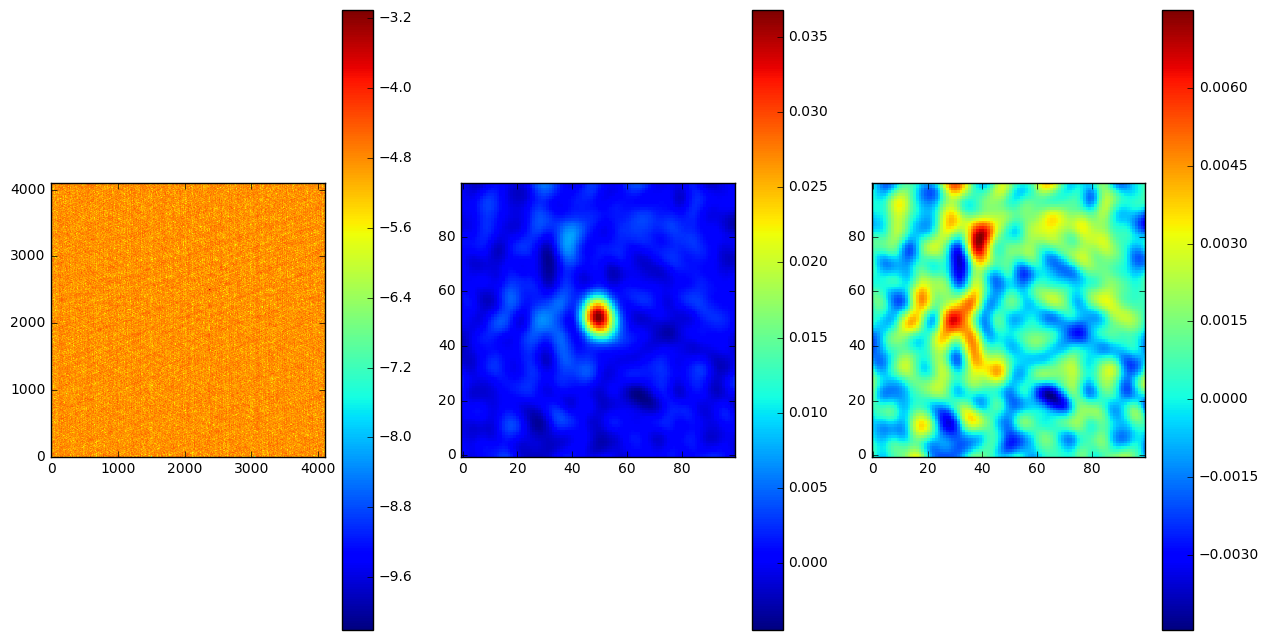

In [6]:
# peak is lower than expected... redo ddcut?
# selcal solution available as selfcal.g0

az, el, az_err, el_err = fitimage(msfile + 'image', fitwindow=40)
fits['57623'] = (az, el, az_err, el_err)

## 57633 Scan 7

In [7]:
# bdf_dedisperse_cut.py -i 7:9514:3 -d 557.0 -e scan7.ddcut 16A-459_TEST_1hr_000.57633.66130137732

sdmfile = '16A-459_TEST_1hr_000.57633.66130137732.scan7.ddcut'
msfile = sdmfile + 'ms'
scan = 7
caltables = ['../pipeline/57633/caltables/cal_57633_3s.G1', '../pipeline/57633/caltables/cal_57633_3s.K1',
             '../pipeline/57633/caltables/cal_57633_3s.B1']

In [9]:
convertms(sdmfile, msfile, scan)

msm = util.tools.msmetadata()
msm.open(msfile)
fieldnames = msm.fieldnames()
print(fieldnames)
targetfield = str(fieldnames.index('FRB121102-off'))

applycal(msfile, caltables, targetfield=targetfield, gainfield=['0','',''], interp=['linear','',''])
makeimage(msfile, field=targetfield, niter=30)

['J0555+3948', 'FRB121102-off']


Image shape: [4096 4096    1    1]
Peak SNR at (2364,2494) = 148.963462759
Beam shape:  2.48987 by 2.28395 (arcsec) at pa 86.5568 (deg) 
1 element(s) fit
05:31:58.70 +- 0.0117841909537"
+033.08.52.481 +- 0.0138307617629"
Fiteak flux: 0.670442232384 Jy
Residual SNR at (2258,2427) = 11.8234015234


/users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:86: RuntimeWarning: divide by zero encountered in log


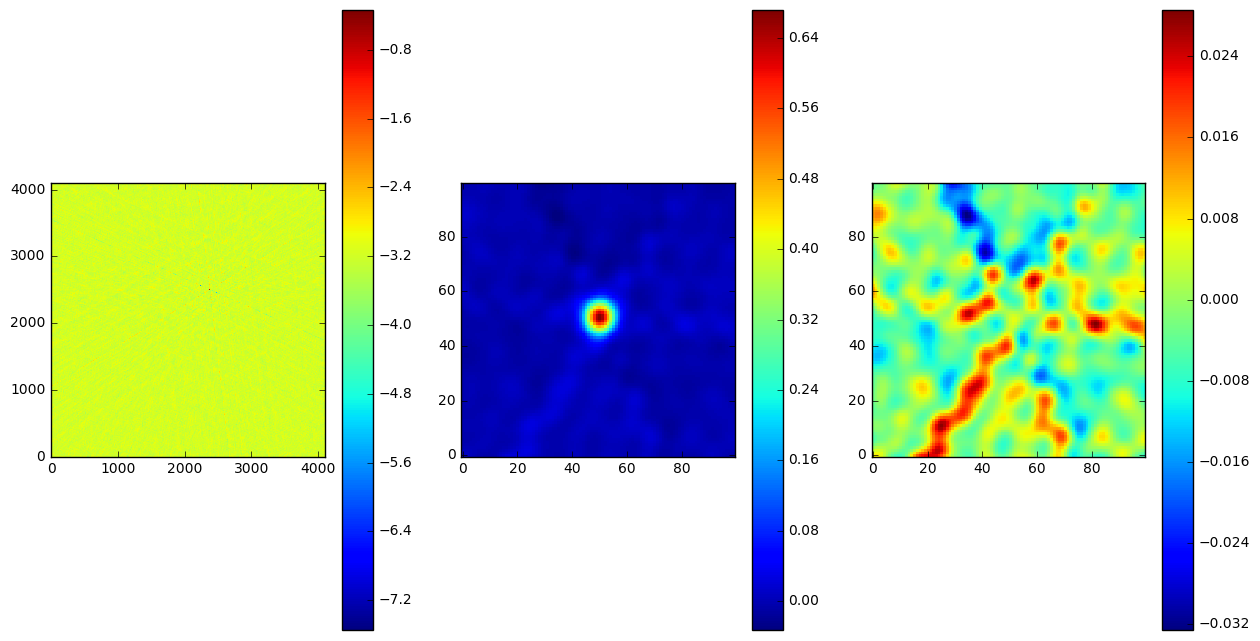

In [8]:
az, el, az_err, el_err = fitimage(msfile + 'image', fitwindow=40)
fits['57633_scan7'] = (az, el, az_err, el_err)

## 57633 Scan 13

In [9]:
# bdf_dedisperse_cut.py -i 13:10544:1 -d 560.0 -e scan13.ddcut 16A-459_TEST_1hr_000.57633.66130137732

sdmfile = '16A-459_TEST_1hr_000.57633.66130137732.scan13.ddcut'
msfile = sdmfile + 'ms'
scan = 13
caltables = ['../pipeline/57633/caltables/cal_57633_3s.G1', '../pipeline/57633/caltables/cal_57633_3s.K1',
             '../pipeline/57633/caltables/cal_57633_3s.B1']

In [15]:
convertms(sdmfile, msfile, scan)

msm = util.tools.msmetadata()
msm.open(msfile)
fieldnames = msm.fieldnames()
print(fieldnames)
targetfield = str(fieldnames.index('FRB121102-off'))

applycal(msfile, caltables, targetfield=targetfield, gainfield=['0','',''], interp=['linear','',''])
makeimage(msfile, field=targetfield, niter=30)

['J0555+3948', 'FRB121102-off']


Image shape: [4096 4096    1    1]
Peak SNR at (2366,2494) = 6.77372210931
Beam shape:  2.61022 by 2.27748 (arcsec) at pa 82.908 (deg) 
1 element(s) fit
05:31:58.70 +- 0.313587506085"
+033.08.52.300 +- 0.286612827676"
Fiteak flux: 0.0247597669725 Jy
Residual SNR at (2670,4069) = 4.83543930086


/users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:86: RuntimeWarning: divide by zero encountered in log


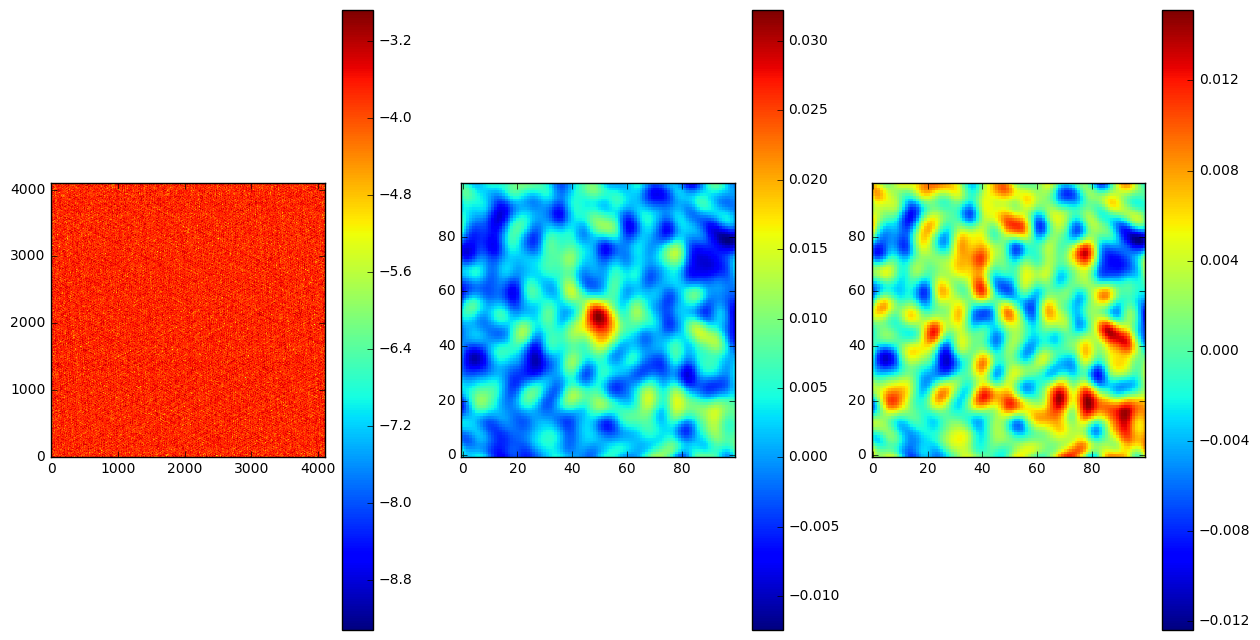

In [12]:
az, el, az_err, el_err = fitimage(msfile + 'image', fitwindow=40)
fits['57633_scan13'] = (az, el, az_err, el_err)

In [11]:
# no strong source in the image. applycal not right?
fits.pop('57633_scan13')

(1.4485288992907792,
 0.5785393182685581,
 0.3135875060846674,
 0.28661282767607604)

## 57638

In [13]:
# 
sdmfile = '16A-496_sb32698778_1_02h00m.57638.42695471065.ddcut'
msfile = sdmfile + 'ms'
scan = 29
caltables = ['../pipeline/57638/caltables/16A-496_sb32698778_1_02h00m.57638.42695471065.avg.ms.hifv_priorcals.s5_3.gc.tbl', 
             '../pipeline/57638/caltables/16A-496_sb32698778_1_02h00m.57638.42695471065.avg.ms.hifv_priorcals.s5_4.opac.tbl', 
             '../pipeline/57638/caltables/16A-496_sb32698778_1_02h00m.57638.42695471065.avg.ms.hifv_priorcals.s5_5.rq.tbl', 
             '../pipeline/57638/caltables/16A-496_sb32698778_1_02h00m.57638.42695471065.avg.ms.finaldelay.k', 
             '../pipeline/57638/caltables/16A-496_sb32698778_1_02h00m.57638.42695471065.avg.ms.finalBPcal.b', 
             '../pipeline/57638/caltables/16A-496_sb32698778_1_02h00m.57638.42695471065.avg.ms.averagephasegain.g', 
             '../pipeline/57638/caltables/16A-496_sb32698778_1_02h00m.57638.42695471065.avg.ms.finalampgaincal.g', 
             '../pipeline/57638/caltables/16A-496_sb32698778_1_02h00m.57638.42695471065.avg.ms.finalphasegaincal.g']

In [19]:
convertms(sdmfile, msfile, scan)

msm = util.tools.msmetadata()
msm.open(msfile)
fieldnames = msm.fieldnames()
print(fieldnames)
targetfield = str(fieldnames.index('FRB121102-off'))

applycal(msfile, caltables, targetfield=targetfield)
makeimage(msfile, field=targetfield, niter=30)

['0137+331=3C48', 'J0555+3948', 'FRB121102-off']


Image shape: [4096 4096    1    1]
Peak SNR at (2364,2494) = 13.0482712273
Beam shape:  1.8716 by 1.72223 (arcsec) at pa 41.8494 (deg) 
1 element(s) fit
05:31:58.71 +- 0.0710931218869"
+033.08.52.495 +- 0.0664847325564"
Fiteak flux: 0.063381066536 Jy
Residual SNR at (3797,18) = 5.48127439929


/users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:86: RuntimeWarning: divide by zero encountered in log


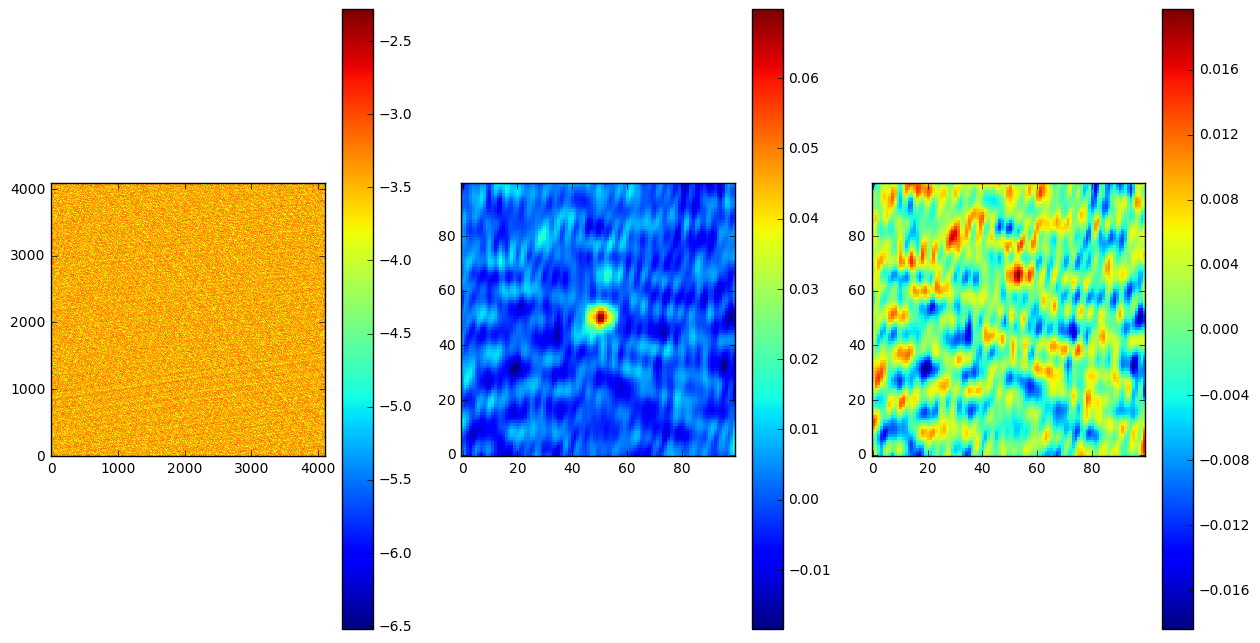

In [14]:
az, el, az_err, el_err = fitimage(msfile + 'image', fitwindow=40)
fits['57638'] = (az, el, az_err, el_err)

## 57643

In [15]:
# bdf_dedisperse_cut.py -i 29:5849:1 -d 560.0 16A-496_sb32698778_1_02h00m_001.57643.38562630787
sdmfile = '16A-496_sb32698778_1_02h00m_001.57643.38562630787.ddcut'
msfile = sdmfile + 'ms'
scan = 29
caltables = ['../pipeline/57643/caltables/16A-496_sb32698778_1_02h00m_001.57643.38562630787.avg.ms.hifv_priorcals.s5_3.gc.tbl', 
             '../pipeline/57643/caltables/16A-496_sb32698778_1_02h00m_001.57643.38562630787.avg.ms.hifv_priorcals.s5_4.opac.tbl',
             '../pipeline/57643/caltables/16A-496_sb32698778_1_02h00m_001.57643.38562630787.avg.ms.hifv_priorcals.s5_5.rq.tbl', 
             '../pipeline/57643/caltables/16A-496_sb32698778_1_02h00m_001.57643.38562630787.avg.ms.finaldelay.k',
             '../pipeline/57643/caltables/16A-496_sb32698778_1_02h00m_001.57643.38562630787.avg.ms.finalBPcal.b', 
             '../pipeline/57643/caltables/16A-496_sb32698778_1_02h00m_001.57643.38562630787.avg.ms.averagephasegain.g', 
             '../pipeline/57643/caltables/16A-496_sb32698778_1_02h00m_001.57643.38562630787.avg.ms.finalampgaincal.g', 
             '../pipeline/57643/caltables/16A-496_sb32698778_1_02h00m_001.57643.38562630787.avg.ms.finalphasegaincal.g']

In [22]:
convertms(sdmfile, msfile, scan)

msm = util.tools.msmetadata()
msm.open(msfile)
fieldnames = msm.fieldnames()
print(fieldnames)
targetfield = str(fieldnames.index('FRB121102-off'))

applycal(msfile, caltables, targetfield=targetfield)
makeimage(msfile, field=targetfield, niter=30)

['0137+331=3C48', 'J0555+3948', 'FRB121102-off']


Image shape: [4096 4096    1    1]
Peak SNR at (2364,2494) = 65.9237643298
Beam shape:  1.97826 by 0.873323 (arcsec) at pa -74.223 (deg) 
1 element(s) fit
05:31:58.70 +- 0.00891390874153"
+033.08.52.545 +- 0.0262415275225"
Fiteak flux: 0.325819778231 Jy
Residual SNR at (2531,2345) = 7.46439158193


/users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:86: RuntimeWarning: divide by zero encountered in log


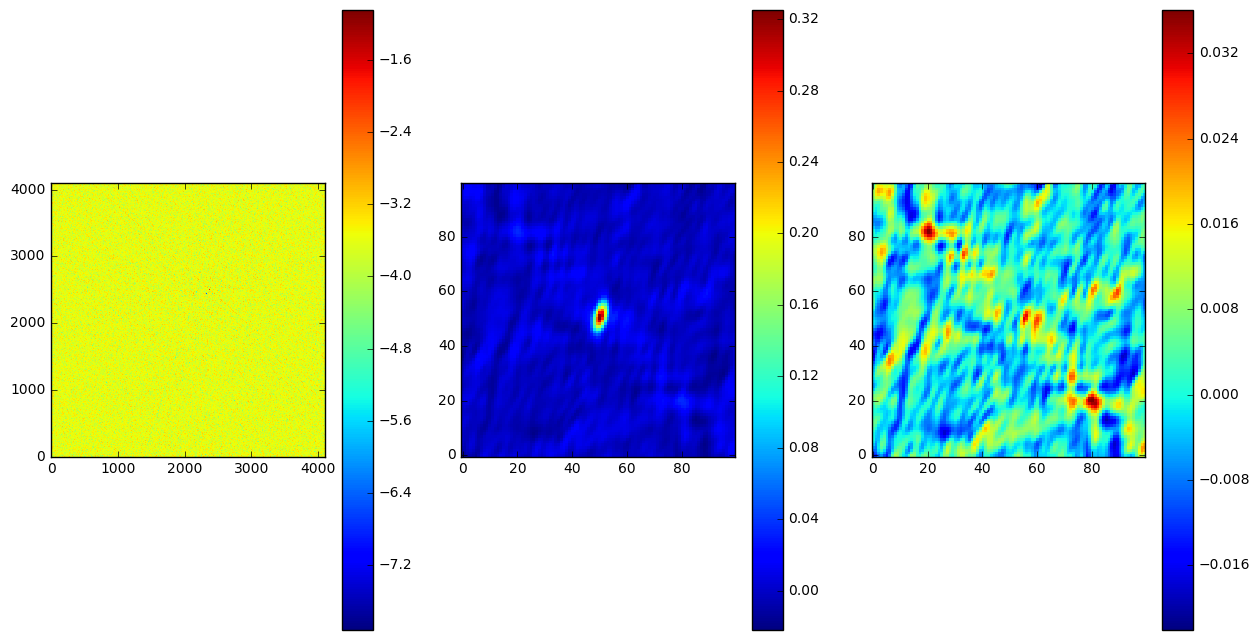

In [16]:
az, el, az_err, el_err = fitimage(msfile + 'image', fitwindow=40)
fits['57643'] = (az, el, az_err, el_err)

## 57645

In [17]:
# bdf_dedisperse_cut.py -i 16:7526:1 -d 546 16A-496_sb32698778_1_02h00m.57645.38915079861
sdmfile = '16A-496_sb32698778_1_02h00m.57645.38915079861.ddcut'
msfile = sdmfile + 'ms'
scan = 16

caltables = ['../pipeline/57645/caltables/16A-496_sb32698778_1_02h00m.57645.38915079861.avg.ms.hifv_priorcals.s5_3.gc.tbl', 
             '../pipeline/57645/caltables/16A-496_sb32698778_1_02h00m.57645.38915079861.avg.ms.hifv_priorcals.s5_4.opac.tbl', 
             '../pipeline/57645/caltables/16A-496_sb32698778_1_02h00m.57645.38915079861.avg.ms.hifv_priorcals.s5_5.rq.tbl', 
             '../pipeline/57645/caltables/16A-496_sb32698778_1_02h00m.57645.38915079861.avg.ms.hifv_priorcals.s5_6.ants.tbl', 
             '../pipeline/57645/caltables/16A-496_sb32698778_1_02h00m.57645.38915079861.avg.ms.finaldelay.k',
             '../pipeline/57645/caltables/16A-496_sb32698778_1_02h00m.57645.38915079861.avg.ms.finalBPcal.b', 
             '../pipeline/57645/caltables/16A-496_sb32698778_1_02h00m.57645.38915079861.avg.ms.averagephasegain.g',
             '../pipeline/57645/caltables/16A-496_sb32698778_1_02h00m.57645.38915079861.avg.ms.finalampgaincal.g', 
             '../pipeline/57645/caltables/16A-496_sb32698778_1_02h00m.57645.38915079861.avg.ms.finalphasegaincal.g']

In [25]:
convertms(sdmfile, msfile, scan)

msm = util.tools.msmetadata()
msm.open(msfile)
fieldnames = msm.fieldnames()
print(fieldnames)
targetfield = str(fieldnames.index('FRB121102-off'))

applycal(msfile, caltables, targetfield=targetfield)

['0137+331=3C48', 'J0555+3948', 'FRB121102-off']


In [26]:
makeimage(msfile, field=targetfield, cell=0.15, spw='0:10~32,1~7')

Image shape: [4096 4096    1    1]
Peak SNR at (2576,2792) = 9.77732959093
Beam shape:  1.30327 by 0.73391 (arcsec) at pa -45.7863 (deg) 
1 element(s) fit
05:31:58.69 +- 0.0672470048251"
+033.08.52.544 +- 0.123688775443"
Fiteak flux: 0.038827251749 Jy
Residual SNR at (682,4071) = 5.03631430451


/users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:86: RuntimeWarning: divide by zero encountered in log


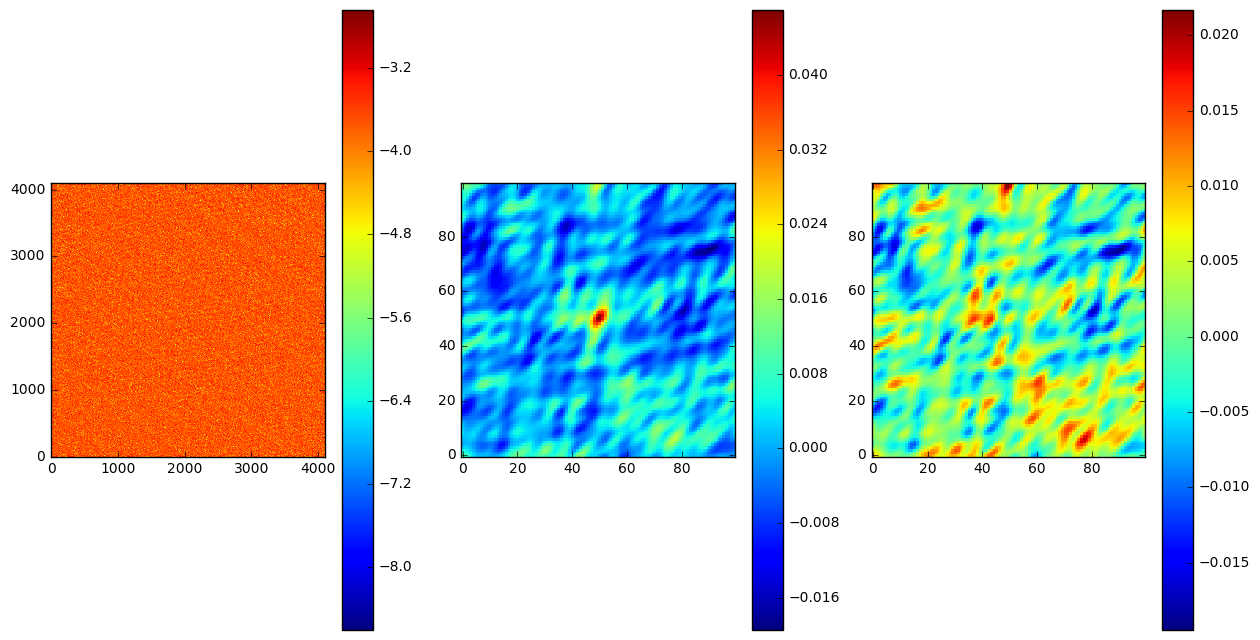

In [18]:
az, el, az_err, el_err = fitimage(msfile + 'image', fitwindow=30)
fits['57645'] = (az, el, az_err, el_err)

## 57646

In [19]:
# bdf_dedisperse_cut.py -i 32:7562:1 -d 557.0 16A-496_sb32698778_1_02h00m_000.57646.38643644676
sdmfile = '16A-496_sb32698778_1_02h00m_000.57646.38643644676.ddcut'
msfile = sdmfile + 'ms'
scan = 32

caltables = ['../pipeline/57646/caltables/16A-496_sb32698778_1_02h00m_000.57646.38643644676.avg.ms.hifv_priorcals.s5_3.gc.tbl',
             '../pipeline/57646/caltables/16A-496_sb32698778_1_02h00m_000.57646.38643644676.avg.ms.hifv_priorcals.s5_4.opac.tbl',
             '../pipeline/57646/caltables/16A-496_sb32698778_1_02h00m_000.57646.38643644676.avg.ms.hifv_priorcals.s5_5.rq.tbl', 
             '../pipeline/57646/caltables/16A-496_sb32698778_1_02h00m_000.57646.38643644676.avg.ms.hifv_priorcals.s5_6.ants.tbl',
             '../pipeline/57646/caltables/16A-496_sb32698778_1_02h00m_000.57646.38643644676.avg.ms.finaldelay.k', 
             '../pipeline/57646/caltables/16A-496_sb32698778_1_02h00m_000.57646.38643644676.avg.ms.finalBPcal.b', 
             '../pipeline/57646/caltables/16A-496_sb32698778_1_02h00m_000.57646.38643644676.avg.ms.averagephasegain.g', 
             '../pipeline/57646/caltables/16A-496_sb32698778_1_02h00m_000.57646.38643644676.avg.ms.finalampgaincal.g', 
             '../pipeline/57646/caltables/16A-496_sb32698778_1_02h00m_000.57646.38643644676.avg.ms.finalphasegaincal.g']

In [29]:
convertms(sdmfile, msfile, scan)

msm = util.tools.msmetadata()
msm.open(msfile)
fieldnames = msm.fieldnames()
print(fieldnames)
targetfield = str(fieldnames.index('FRB121102-off'))

applycal(msfile, caltables, targetfield=targetfield)
makeimage(msfile, field=targetfield, niter=30)

['0137+331=3C48', 'J0555+3948', 'FRB121102-off']


Image shape: [4096 4096    1    1]
Peak SNR at (2364,2494) = 10.3997470092
Beam shape:  1.21918 by 0.726979 (arcsec) at pa -47.2422 (deg) 
1 element(s) fit
05:31:58.70 +- 0.0454832871193"
+033.08.52.557 +- 0.0476193149737"
Fiteak flux: 0.0499973686981 Jy
Residual SNR at (0,4049) = 5.69256514792


/users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:86: RuntimeWarning: divide by zero encountered in log


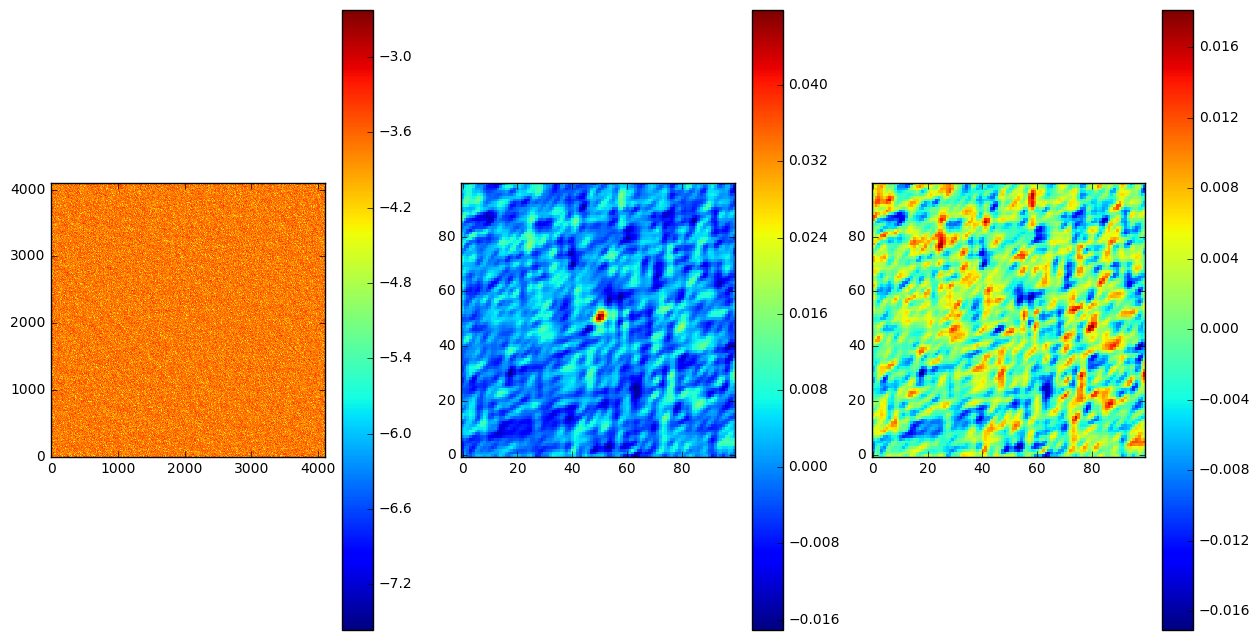

In [20]:
az, el, az_err, el_err = fitimage(msfile + 'image', fitwindow=40)
fits['57646'] = (az, el, az_err, el_err)

## 57648

In [21]:
# bdf_dedisperse_cut.py -i 25:3879:1 -d 560.0 16A-496_sb32698778_1_02h00m_000.57648.37452900463
sdmfile = '16A-496_sb32698778_1_02h00m_000.57648.37452900463.ddcut'
msfile = sdmfile + 'ms'
scan = 25
caltables = ['../pipeline/57648/caltables/16A-496_sb32698778_1_02h00m_000.57648.37452900463.avg.ms.hifv_priorcals.s5_3.gc.tbl',
             '../pipeline/57648/caltables/16A-496_sb32698778_1_02h00m_000.57648.37452900463.avg.ms.hifv_priorcals.s5_4.opac.tbl',
             '../pipeline/57648/caltables/16A-496_sb32698778_1_02h00m_000.57648.37452900463.avg.ms.hifv_priorcals.s5_5.rq.tbl',
             '../pipeline/57648/caltables/16A-496_sb32698778_1_02h00m_000.57648.37452900463.avg.ms.finaldelay.k',
             '../pipeline/57648/caltables/16A-496_sb32698778_1_02h00m_000.57648.37452900463.avg.ms.finalBPcal.b',
             '../pipeline/57648/caltables/16A-496_sb32698778_1_02h00m_000.57648.37452900463.avg.ms.averagephasegain.g',
             '../pipeline/57648/caltables/16A-496_sb32698778_1_02h00m_000.57648.37452900463.avg.ms.finalampgaincal.g',
             '../pipeline/57648/caltables/16A-496_sb32698778_1_02h00m_000.57648.37452900463.avg.ms.finalphasegaincal.g']

In [32]:
convertms(sdmfile, msfile, scan)

msm = util.tools.msmetadata()
msm.open(msfile)
fieldnames = msm.fieldnames()
print(fieldnames)
targetfield = str(fieldnames.index('FRB121102-off'))

applycal(msfile, caltables, targetfield=targetfield)
makeimage(msfile, field=targetfield, niter=30)

['0137+331=3C48', 'J0555+3948', 'FRB121102-off']


Image shape: [4096 4096    1    1]
Peak SNR at (2364,2494) = 18.4236506151
Beam shape:  1.33152 by 0.754416 (arcsec) at pa -51.501 (deg) 
1 element(s) fit
05:31:58.70 +- 0.0316497900514"
+033.08.52.567 +- 0.0296652085137"
Fiteak flux: 0.0860404580009 Jy
Residual SNR at (3380,0) = 6.11310983682


/users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:86: RuntimeWarning: divide by zero encountered in log


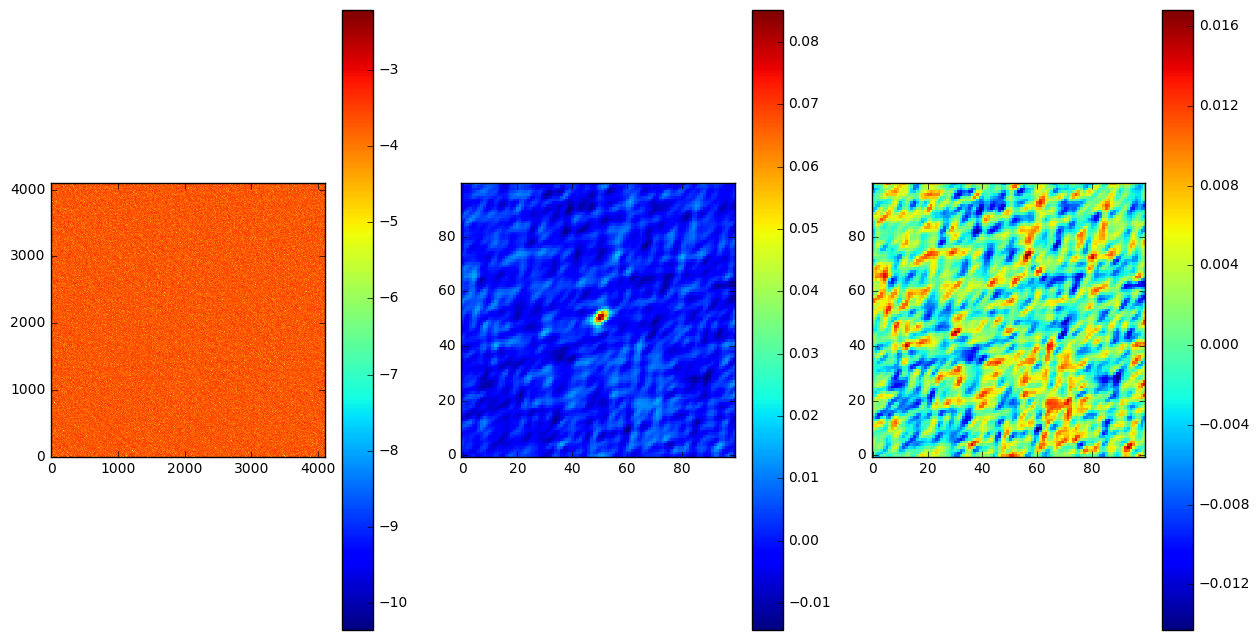

In [22]:
az, el, az_err, el_err = fitimage(msfile + 'image', fitwindow=40)
fits['57648'] = (az, el, az_err, el_err)

## 57649

In [23]:
# bdf_dedisperse_cut.py -i 31:10600:1 -d 557.0 16A-496_sb32698778_1_02h00m_001.57649.37461215278
sdmfile = '16A-496_sb32698778_1_02h00m_001.57649.37461215278.ddcut'
msfile = sdmfile + 'ms'
scan = 31

caltables = ['../pipeline/57649/caltables/16A-496_sb32698778_1_02h00m_001.57649.37461215278.avg.ms.hifv_priorcals.s5_3.gc.tbl',
             '../pipeline/57649/caltables/16A-496_sb32698778_1_02h00m_001.57649.37461215278.avg.ms.hifv_priorcals.s5_4.opac.tbl',
             '../pipeline/57649/caltables/16A-496_sb32698778_1_02h00m_001.57649.37461215278.avg.ms.hifv_priorcals.s5_5.rq.tbl',
             '../pipeline/57649/caltables/16A-496_sb32698778_1_02h00m_001.57649.37461215278.avg.ms.finaldelay.k',
             '../pipeline/57649/caltables/16A-496_sb32698778_1_02h00m_001.57649.37461215278.avg.ms.finalBPcal.b',
             '../pipeline/57649/caltables/16A-496_sb32698778_1_02h00m_001.57649.37461215278.avg.ms.averagephasegain.g',
             '../pipeline/57649/caltables/16A-496_sb32698778_1_02h00m_001.57649.37461215278.avg.ms.finalampgaincal.g',
             '../pipeline/57649/caltables/16A-496_sb32698778_1_02h00m_001.57649.37461215278.avg.ms.finalphasegaincal.g']

In [35]:
convertms(sdmfile, msfile, scan)

msm = util.tools.msmetadata()
msm.open(msfile)
fieldnames = msm.fieldnames()
print(fieldnames)
targetfield = str(fieldnames.index('FRB121102-off'))

applycal(msfile, caltables, targetfield=targetfield)
makeimage(msfile, field=targetfield, niter=30)

['0137+331=3C48', 'J0555+3948', 'FRB121102-off']


Image shape: [4096 4096    1    1]
Peak SNR at (2364,2494) = 34.1770842264
Beam shape:  1.28086 by 0.780549 (arcsec) at pa -55.3542 (deg) 
1 element(s) fit
05:31:58.70 +- 0.016036782394"
+033.08.52.490 +- 0.0200194478561"
Fiteak flux: 0.158779426657 Jy
Residual SNR at (4067,7) = 6.58717443223


/users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:86: RuntimeWarning: divide by zero encountered in log


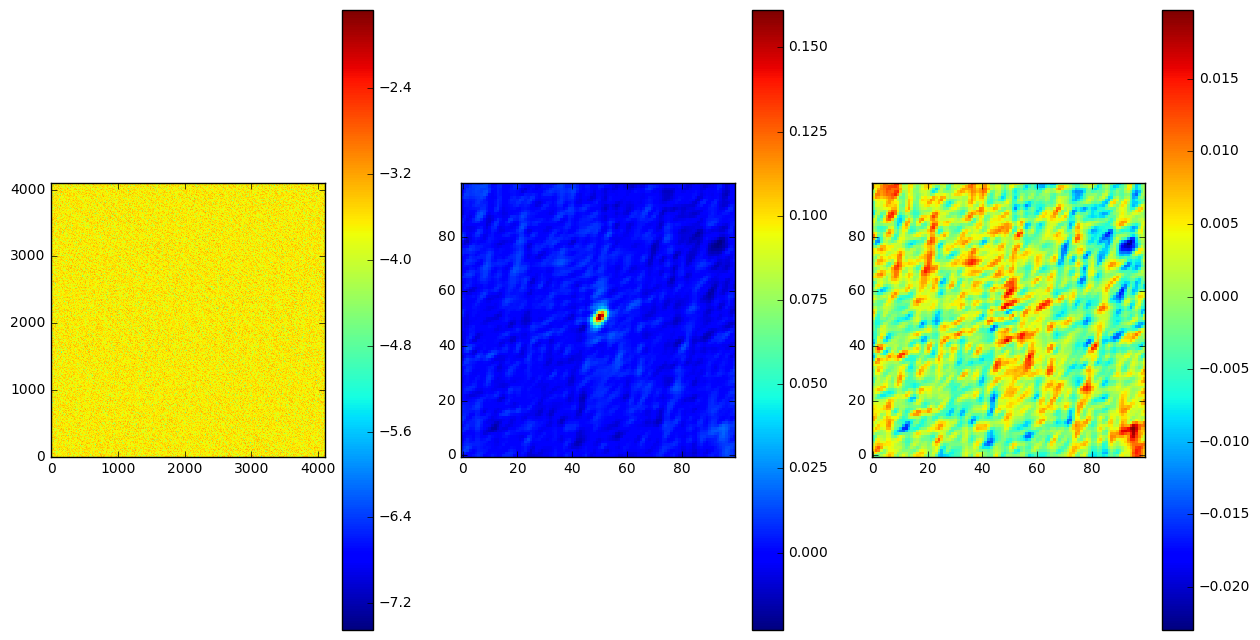

In [24]:
az, el, az_err, el_err = fitimage(msfile + 'image', fitwindow=40)
fits['57649'] = (az, el, az_err, el_err)

## Show fits

In [25]:
# single-epoch localization
# con_casa = coordinates.SkyCoord('5h31m58.69495s', '+33d8m52.56074s', frame='icrs') # imfit to B+BnC data (Robert)
# con_az_err = 0.01209
# con_el_err = 0.00997

con_casa = {}
con_casa_err = {}
con_casa['57623'] = coordinates.SkyCoord(82.99460372*units.deg, 33.14796277*units.deg, frame='icrs')
con_casa_err['57623'] = (0.00000995, 0.00000507 )
# constant source same for scan 7 and 13
con_casa['57633_scan7'] = coordinates.SkyCoord(82.99458496*units.deg, 33.14795133*units.deg, frame='icrs')
con_casa_err['57633_scan7'] = (0.00000723, 0.00000436)
con_casa['57633_scan13'] = coordinates.SkyCoord(82.99458496*units.deg, 33.14795133*units.deg, frame='icrs')
con_casa_err['57633_scan13'] = (0.00000723, 0.00000436)
con_casa['57638'] = coordinates.SkyCoord(82.99457816*units.deg, 33.14793007*units.deg, frame='icrs')
con_casa_err['57638'] = (0.00001094, 0.00000303 )
con_casa['57643'] = coordinates.SkyCoord(82.99458527*units.deg, 33.14792721*units.deg, frame='icrs')
con_casa_err['57643'] = (0.00001317, 0.00000558)
con_casa['57645'] = coordinates.SkyCoord(82.99458191*units.deg, 33.14792454*units.deg, frame='icrs')
con_casa_err['57645'] = (0.00000336, 0.00000354)
con_casa['57646'] = coordinates.SkyCoord(82.99458183*units.deg, 33.14792251*units.deg, frame='icrs')
con_casa_err['57646'] = (0.00000636, 0.00000622)
con_casa['57648'] = coordinates.SkyCoord(82.99458296*units.deg, 33.14792605*units.deg, frame='icrs')
con_casa_err['57648'] = (0.00000320, 0.00000322)
con_casa['57649'] = coordinates.SkyCoord(82.99457118*units.deg, 33.14792951*units.deg, frame='icrs')
con_casa_err['57649'] = (0.00000457, 0.00000460)

con_casa['bryan2'] = coordinates.SkyCoord('05h31m58.69916s', '33d08m52.5578s', frame='icrs')
con_casa_err['bryan2'] = (0.0036/3600, 0.0026/3600)
con_casa['bryan3'] = coordinates.SkyCoord('05h31m58.69986s', '33d08m52.5519s', frame='icrs')
con_casa_err['bryan3'] = (0.0026/3600, 0.00203/3600)

con_casa['robert'] = coordinates.SkyCoord('05h31m58.69495s', '33d08m52.56074s', frame='icrs')
con_casa_err['robert'] = (3.4e-6, 2.8e-6)

(-0.20000000000000001,
 0.10000000000000003,
 -0.15000000000000002,
 0.15000000000000002)

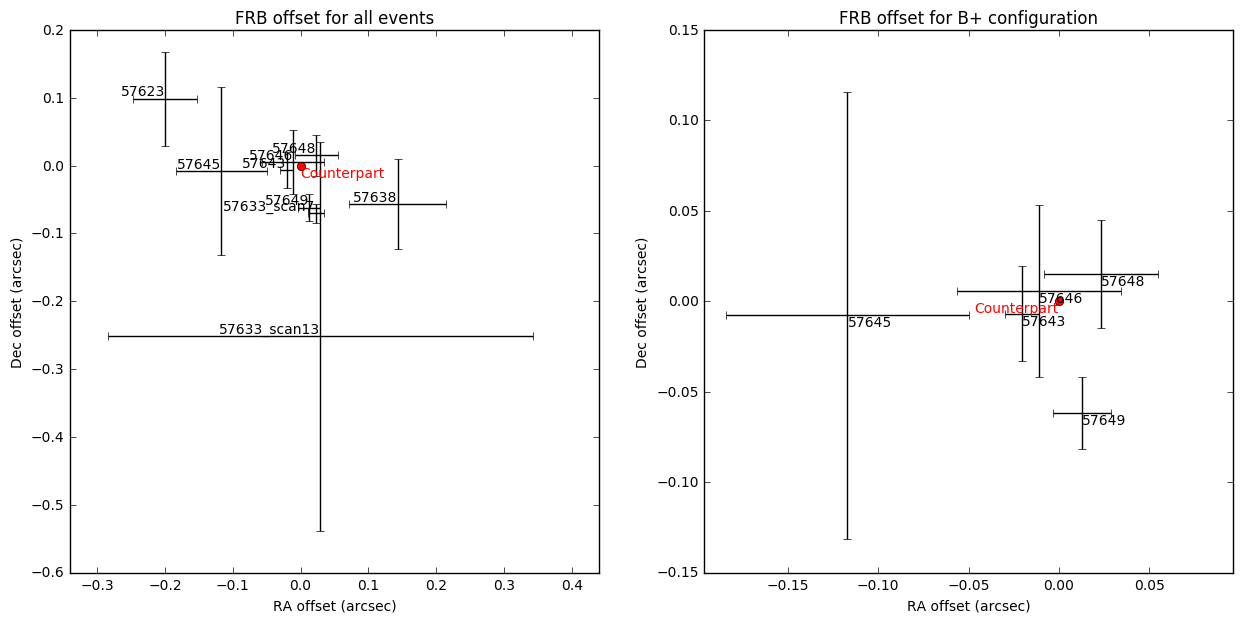

In [27]:
pl.figure(figsize=(15,7))
for event in fits:
    # get the fit
    (az, el, frb_az_err, frb_el_err) = fits[event]
    fit = coordinates.SkyCoord(az*units.rad, el*units.rad, frame='icrs')

    # get the constant source
#    con = con_casa[event]
#    con_az_err, con_el_err = con_casa_err[event]
    con = con_casa['bryan3']
    con_az_err, con_el_err = con_casa_err['bryan3']
    
    raoff, decoff = con.spherical_offsets_to(fit)
    con_az_err = con_az_err*3600
    con_el_err = con_el_err*3600
    az_err = np.sqrt(frb_az_err**2 + con_az_err**2)
    el_err = np.sqrt(frb_el_err**2 + con_el_err**2)
    
    pl.subplot(121)
    pl.errorbar(raoff.arcsec, decoff.arcsec, xerr=az_err, yerr=el_err, fmt='kx', ecolor='k', ms=0)
    pl.text(raoff.arcsec, decoff.arcsec, event, horizontalalignment='right', verticalalignment='bottom')
    if (int(event.split('_')[0]) > 57638):
        pl.subplot(122)
        pl.errorbar(raoff.arcsec, decoff.arcsec, xerr=az_err, yerr=el_err, fmt='kx', ecolor='k', ms=0)
        pl.text(raoff.arcsec, decoff.arcsec, event, horizontalalignment='left', verticalalignment='top')
    
pl.subplot(121)
pl.title('FRB offset for all events')
pl.plot(0, 0, 'ro')
pl.text(0, 0, 'Counterpart', horizontalalignment='left', verticalalignment='top', color='r')
pl.xlabel('RA offset (arcsec)')
pl.ylabel('Dec offset (arcsec)')
pl.axis('equal')

pl.subplot(122)
pl.title('FRB offset for B+ configuration')
pl.plot(0, 0, 'ro')
pl.text(0, 0, 'Counterpart', horizontalalignment='right', verticalalignment='top', color='r')
pl.xlabel('RA offset (arcsec)')
pl.ylabel('Dec offset (arcsec)')
pl.axis('equal')

('57649', 0.012749463190594997, -0.061757968515792974, 0.01624618076814972, 0.020122107058195182)
('57648', 0.02320710721101034, 0.015086680653671511, 0.03175640424063924, 0.029734584176735631)
('57646', -0.011091937314871934, 0.005557108164724566, 0.045557539520633884, 0.047662564540323117)
('57645', -0.1169476164064148, -0.007812131894090439, 0.067297248516913905, 0.12370543266418685)
('57643', -0.020547341785102, -0.0069640802171051985, 0.0092853523924660512, 0.026319929078853957)


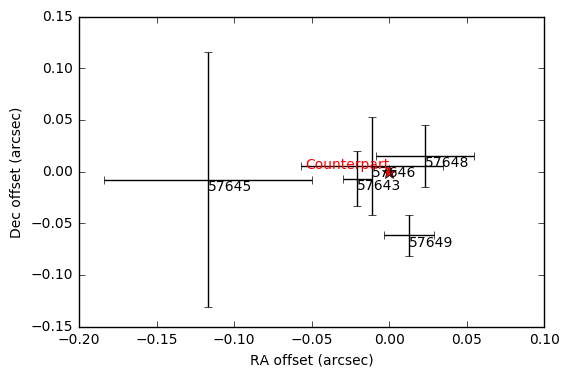

In [28]:
for event in fits:
    # get the fit
    (az, el, frb_az_err, frb_el_err) = fits[event]
    fit = coordinates.SkyCoord(az*units.rad, el*units.rad, frame='icrs')

# get the constant source location
#    con = con_casa[event]
#    con_az_err, con_el_err = con_casa_err[event]
    con = con_casa['bryan3']
    con_az_err, con_el_err = con_casa_err['bryan3']
    
    raoff, decoff = con.spherical_offsets_to(fit)
    con_az_err = con_az_err*3600
    con_el_err = con_el_err*3600
    az_err = np.sqrt(frb_az_err**2 + con_az_err**2)
    el_err = np.sqrt(frb_el_err**2 + con_el_err**2)

    if (int(event.split('_')[0]) > 57638):
#    if (int(event.split('_')[0]) > 0):
        pl.errorbar(raoff.arcsec, decoff.arcsec, xerr=az_err, yerr=el_err, fmt='kx', ecolor='k', ms=0)
        pl.text(raoff.arcsec, decoff.arcsec, event, horizontalalignment='left', verticalalignment='top')

        print(event, raoff.arcsec, decoff.arcsec, az_err, el_err)
pl.plot(0, 0, 'r*', linewidth=0, ms=10)
pl.text(0, 0, 'Counterpart', horizontalalignment='right', verticalalignment='bottom', color='r')
pl.xlabel('RA offset (arcsec)')
pl.ylabel('Dec offset (arcsec)')

In [78]:
azall=0.
elall=0.
azeall=0.
eleall=0.
for event in fits:
    # get the fit
    if (int(event.split('_')[0]) > 57638):
        (az, el, frb_az_err, frb_el_err) = fits[event]
        azall += az/frb_az_err**2
        elall += el/frb_el_err**2
        azeall += 1./frb_az_err**2
        eleall += 1./frb_el_err**2
fit = coordinates.SkyCoord(azall/azeall*units.rad, elall/eleall*units.rad, frame='icrs')
print(fit.ra.hms, fit.dec.dms)
print(np.sqrt(1./azeall), np.sqrt(1./eleall))

(hms_tuple(h=5.0, m=31.0, s=58.69890907007985), dms_tuple(d=33.0, m=8.0, s=52.525938606119098))
(0.0074172897047868674, 0.013374984767308608)


## Burst zoom figure

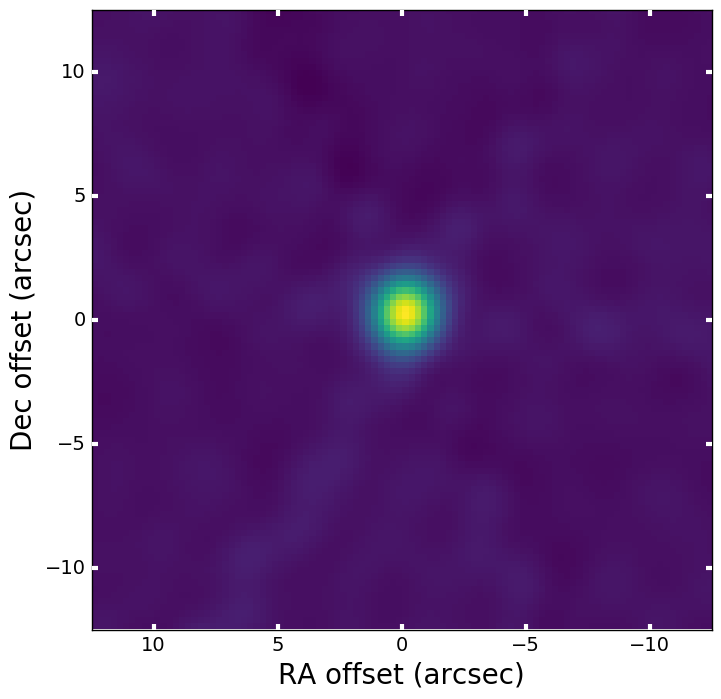

In [9]:
msfile = '16A-459_TEST_1hr_000.57633.66130137732.scan7.ddcutms'
ia = util.tools.image()
ia.open(msfile + 'image')
dd = ia.summary()
npixx,npixy,nch,npol = dd['shape']
imvals = ia.getchunk(0, int(npixx))[:,:,0,0]
peakx, peaky = np.where(imvals.max() == imvals)
displaywindow=100
extent = (1*0.25*displaywindow/2, -0.25*displaywindow/2, -0.25*displaywindow/2, 0.25*displaywindow/2)

# show results
fig = pl.figure(figsize=(8,8))
ax = fig.add_subplot(111)
pl.imshow(imvals[peakx[0]-displaywindow/2:peakx[0]+displaywindow/2, peaky[0]-displaywindow/2:peaky[0]+displaywindow/2],
          interpolation='nearest', cmap='viridis', origin='bottom', extent=extent)
pl.xlabel('RA offset (arcsec)', fontsize=20)
pl.ylabel('Dec offset (arcsec)', fontsize=20)
xt = pl.setp(ax.get_xticklabels(), fontsize=14)
yt = pl.setp(ax.get_yticklabels(), fontsize=14)
ax.xaxis.set_tick_params(width=3, color='w')
ax.yaxis.set_tick_params(width=3, color='w')

In [14]:
print(dd)

{'ndim': 4, 'defaultmask': '', 'incr': array([ -1.21203420e-06,   1.21203420e-06,   1.00000000e+00,
         1.02393411e+09]), 'hasmask': False, 'refval': array([  1.44898689e+00,   5.77999719e-01,   1.00000000e+00,
         2.99880703e+09]), 'messages': array([], 
      dtype='|S1'), 'masks': array([], 
      dtype='|S1'), 'axisnames': array(['Right Ascension', 'Declination', 'Stokes', 'Frequency'], 
      dtype='|S16'), 'axisunits': array(['rad', 'rad', '', 'Hz'], 
      dtype='|S4'), 'shape': array([4096, 4096,    1,    1], dtype=int32), 'restoringbeam': {'major': {'value': 2.4898743629455566, 'unit': 'arcsec'}, 'positionangle': {'value': 86.55677032470703, 'unit': 'deg'}, 'minor': {'value': 2.283949851989746, 'unit': 'arcsec'}}, 'refpix': array([ 2048.,  2048.,     0.,     0.]), 'unit': 'Jy/beam', 'tileshape': array([256, 128,   1,   1], dtype=int32), 'imagetype': 'Intensity'}


In [15]:
np.degrees(1.21203420e-06)*3600

0.24999999942785445